# Plot the SHAP Values

In [95]:
from pathlib import Path
import os
import warnings
from collections import namedtuple

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jovyan/ml_drought


In [96]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [97]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

In [98]:
# EXPERIMENT =      'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
EXPERIMENT =      'one_month_forecast_BASE_static_vars'
# TRUE_EXPERIMENT = 'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
TRUE_EXPERIMENT = 'one_month_forecast'
TARGET_VAR =      'boku_VCI'

assert (data_dir / f'models/{EXPERIMENT}').exists()
assert (data_dir / f'models/{TRUE_EXPERIMENT}').exists()

print((data_dir / f'models/{EXPERIMENT}').as_posix())

data/models/one_month_forecast


# Read in the data

In [99]:
X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
static_ds = xr.open_dataset(data_dir / "features/static/data.nc")

ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [100]:
print("TRAINING DATA")
display(ds)
print('\n\n')
print("TARGET DATA")
display(y_test)

TRAINING DATA


<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lat         (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    boku_VCI    (time, lat, lon) float64 100.0 100.0 98.82 ... 11.94 78.34 40.51
    VCI3M       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    modis_ndvi  (time, lat, lon) float64 0.688 0.5456 0.7328 ... nan nan nan
    VCI         (time, lat, lon) float64 57.69 89.55 63.82 45.12 ... nan nan nan
    precip      (time, lat, lon) float64 102.0 107.6 122.3 111.1 ... nan nan nan
    E           (time, lat, lon) float64 85.9 60.61 60.61 57.43 ... nan nan nan
    Eb          (time, lat, lon) float64 3.518 1.266 1.266 2.995 ... nan nan nan
    SMroot      (time, lat, lon) float64 0.2638 0.2245 0.2245 ... nan nan nan
    SMsurf      (time, lat, lon) float64 0.2978 0.2648 0.2648 ... nan nan nan
    p84.162     (time, lat, lon) float64 1.45e-05 -5.456e-05 ... nan nan
    pev         (time, lat, lon) float64 -0.005993 -0.006077 ... nan nan
    sp          (time, lat, lon) float64 8.862e+04 8.927e+04 ... nan nan
    t2m         (time, lat, lon) float64 297.5 298.4 297.4 296.2 ... nan nan nan
    tp          (time, lat, lon) float64 0.003657 0.00285 0.004386 ... nan nan




TARGET DATA


<xarray.Dataset>
Dimensions:   (lat: 45, lon: 35, time: 36)
Coordinates:
  * lat       (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
  * lon       (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * time      (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2018-12-31
Data variables:
    boku_VCI  (time, lat, lon) float64 64.45 52.16 97.37 96.48 ... nan nan nan

In [101]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1].where(~mask)

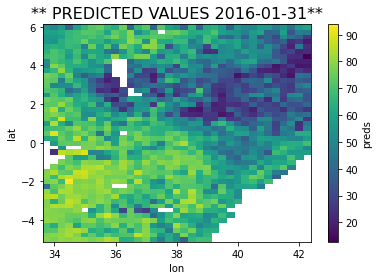

In [102]:
fig, ax = plt.subplots()
time_ix = 0
time = ealstm_pred.isel(time=time_ix).time.values
ealstm_pred.isel(time=time_ix).plot(ax=ax)
ax.set_title(f"** PREDICTED VALUES {str(time).split('T')[0]}**", size=16);

### Load in the models

In [103]:
from src.models import load_model

ealstm = load_model(data_dir / 'models' / EXPERIMENT / 'ealstm' / 'model.pt')
ealstm.models_dir = data_dir / 'models' / EXPERIMENT

ealstm.experiment = TRUE_EXPERIMENT
ealstm.features_per_month  # x.shape[-1] = the number of features in dynamic data 

16

In [104]:
dl = ealstm.get_dataloader('train', batch_file_size=1, shuffle_data=False)
train_iter = iter(dl)
static_data = train_iter.static
print(f"N Vars: {len(list(static_data.data_vars))}")
static_data

N Vars: 29


<xarray.Dataset>
Dimensions:                                     (lat: 45, lon: 35)
Coordinates:
  * lat                                         (lat) float32 6.0 5.75 ... -5.0
  * lon                                         (lon) float32 33.75 ... 42.25
Data variables:
    precip_global_mean                          (lat, lon) float64 ...
    E_global_mean                               (lat, lon) float64 ...
    SMroot_global_mean                          (lat, lon) float64 ...
    SMsurf_global_mean                          (lat, lon) float64 ...
    pev_global_mean                             (lat, lon) float64 ...
    t2m_global_mean                             (lat, lon) float64 ...
    precip_pixel_mean                           (lat, lon) float64 ...
    E_pixel_mean                                (lat, lon) float64 ...
    SMroot_pixel_mean                           (lat, lon) float64 ...
    SMsurf_pixel_mean                           (lat, lon) float64 ...
    pev_pixel_mean                              (lat, lon) float64 ...
    t2m_pixel_mean                              (lat, lon) float64 ...
    topography                                  (lat, lon) float32 ...
    lc_class                                    (lat, lon) float64 ...
    lc_class_group                              (lat, lon) int64 ...
    no_data_one_hot                             (lat, lon) float64 ...
    cropland_rainfed_one_hot                    (lat, lon) float64 ...
    herbaceous_cover_one_hot                    (lat, lon) float64 ...
    tree_or_shrub_cover_one_hot                 (lat, lon) float64 ...
    cropland_irrigated_or_postflooding_one_hot  (lat, lon) float64 ...
    tree_cover_one_hot                          (lat, lon) float64 ...
    shrubland_one_hot                           (lat, lon) float64 ...
    grassland_one_hot                           (lat, lon) float64 ...
    lichens_and_mosses_one_hot                  (lat, lon) float64 ...
    urban_areas_one_hot                         (lat, lon) float64 ...
    bare_areas_one_hot                          (lat, lon) float64 ...
    water_bodies_one_hot                        (lat, lon) float64 ...
    permanent_snow_and_ice_one_hot              (lat, lon) float64 ...
    slt                                         (lat, lon) float64 ...

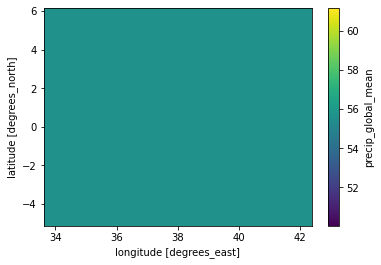

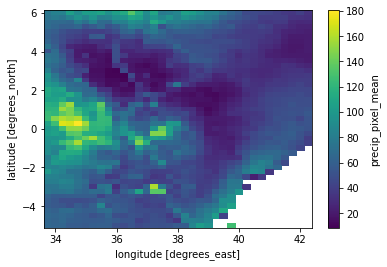

In [105]:
global_vars = [v for v in static_data if 'global' in v]
pixel_vars = [v for v in static_data if 'pixel' in v]

fig, ax = plt.subplots()
static_data[global_vars[0]].plot(ax=ax)
fig, ax = plt.subplots()
static_data[pixel_vars[0]].plot(ax=ax)

# Open SHAP analysis

In [106]:
from pandas.tseries.offsets import MonthEnd


def get_timestep_from_date_str(date_str) -> pd.Timestamp:
    return pd.to_datetime(date_str, format="%Y_%m") + MonthEnd()


def open_shap_analysis(model) -> Dict[str, namedtuple]:  # type: ignore
    """Read the data from the SHAP analysis run in the other functions"""
    ShapValues = namedtuple(
        "ShapValues", ["date_str", "target_time", "historical", "pred_month", "static"]
    )

    analysis_dir = model.model_dir / "analysis"
    dirs = [d for d in analysis_dir.iterdir() if len(list(d.glob("*.nc"))) > 0]

    out_dict = {}
    for shap_analysis_dir in dirs:
        shap = ShapValues(
            date_str=shap_analysis_dir.name,
            target_time=get_timestep_from_date_str(shap_analysis_dir.name),
            historical=xr.open_dataset(shap_analysis_dir / "shap_historical_ds.nc"),
            pred_month=xr.open_dataset(shap_analysis_dir / "shap_pred_month.nc"),
            static=xr.open_dataset(shap_analysis_dir / "shap_static.nc"),
        )
        out_dict[shap_analysis_dir.name] = shap

    return out_dict

In [107]:
shap = open_shap_analysis(ealstm)
shap.keys()

dict_keys(['2016_4', '2016_5', '2017_11', '2018_1', '2017_12', '2018_7', '2018_9', '2016_1', '2017_6', '2016_7', '2018_10', '2018_8', '2017_3', '2017_1', '2017_4', '2018_11', '2016_6', '2016_8', '2018_4', '2018_5', '2016_2', '2017_7', '2016_9', '2017_5', '2017_8', '2016_10', '2016_12', '2018_12', '2017_9', '2016_3', '2018_6', '2018_3', '2017_10', '2016_11', '2017_2', '2018_2'])

# Get the X_test data

In [108]:
from src.utils import create_shape_aligned_climatology
?create_shape_aligned_climatology

Signature:
create_shape_aligned_climatology(
    ds: xarray.core.dataset.Dataset,
    clim: xarray.core.dataset.Dataset,
    variable: str,
    time_period: str,
)
Docstring:
match the time dimension of `clim` to the shape of `ds` so that can
perform simple calculations / arithmetic on the values of clim

Arguments:
---------
ds : xr.Dataset
    the dataset with the raw values that you are comparing to climatology

clim: xr.Dataset
    the climatology values for a given `time_period`

variable: str
    name of the variable that you are comparing to the climatology

time_period: str
    the period string used to calculate the climatology
     time_period = {'dayofyear', 'season', 'month'}

Notes:
    1. assumes that `lat` and `lon` are the
    coord names in ds
File:      ~/ml_drought/src/utils.py
Type:      function


In [109]:
# create pixel-mean and pixel_std
means = X_train.mean(dim='time').drop(ealstm.ignore_vars)
stds = X_train.std(dim='time').drop(ealstm.ignore_vars)
ones = xr.ones_like(X_test.drop(ealstm.ignore_vars))
variable='precip'

means = ones*means
stds = ones*stds
# create_shape_aligned_climatology(X_train, means, variable, time_period='month')

norm_x_test = (x_test - means) / stds
norm_x_test

<xarray.Dataset>
Dimensions:   (lat: 45, lon: 35, time: 38)
Coordinates:
  * lat       (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
  * lon       (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * time      (time) datetime64[ns] 2015-10-31 2015-11-30 ... 2018-11-30
Data variables:
    VCI3M     (time, lat, lon) float64 -1.331 -0.4731 0.1381 ... nan nan nan
    boku_VCI  (time, lat, lon) float64 -1.388 -1.472 -0.3746 ... nan nan nan
    precip    (time, lat, lon) float64 0.9645 0.9505 1.151 ... nan nan nan
    E         (time, lat, lon) float64 1.124 1.07 1.07 0.953 ... nan nan nan nan
    SMroot    (time, lat, lon) float64 0.8286 0.8768 0.8768 ... nan nan nan
    SMsurf    (time, lat, lon) float64 1.094 1.097 1.097 0.99 ... nan nan nan
    pev       (time, lat, lon) float64 0.5658 0.6764 0.7373 ... -0.1302 -0.1302
    t2m       (time, lat, lon) float64 -0.3053 -0.2463 -0.2162 ... 0.5605 0.571

In [110]:
# get x_test only with predictor variables
x_test = X_test.drop(ealstm.ignore_vars)
x_test

# normalize the X data to compare with the shap values
# NEED TO NORMALIZE RELATIVE TO THE PIXEL MEANS ...
norm_x_test = []
for var in list(x_test.data_vars):
    norm_x_test.append((
        x_test[var] - ealstm.normalizing_dict[var]['mean']
    ) / ealstm.normalizing_dict[var]['std'])
    
    
norm_x_test = xr.merge(norm_x_test)

In [146]:
norm_ds = ds.drop(ealstm.ignore_vars)

# normalize the X data to compare with the shap values
# NEED TO NORMALIZE RELATIVE TO THE PIXEL MEANS ...
list_ds = []
for var in list(x_test.data_vars):
    list_ds.append((
        norm_ds[var] - ealstm.normalizing_dict[var]['mean']
    ) / ealstm.normalizing_dict[var]['std'])
    
    
norm_ds = xr.merge(list_ds)

# Plot SHAP files

In [111]:
def plot_shap_obs_pairs(shap_ds: xr.Dataset, obs_ds: xr.Dataset, variables: List[str], shap_plot_kwargs: Dict, obs_plot_kwargs: Dict, norm: bool = False) -> None:
    n_variables = len(variables)
    assert np.unique(shap_ds.time.values).shape == (1,), "Only works for a single time"
    fig, axs = plt.subplots(n_variables, 2, figsize=(6*2, 4*n_variables))
    
    for ix, variable in enumerate(variables):
        ax_row = axs[ix, :]
        time = pd.to_datetime(
            shap_ds.time.values
        )

        # plot shap values
        shap_ds[variable].plot(ax=ax_row[0], **shap_plot_kwargs)
        ax_row[0].set_title(f"{time._date_repr}: SHAP {variable}")

        # plot the observed data
        obs_ds.sel(time=time)[variable].where(~mask).plot(ax=ax_row[1], **obs_plot_kwargs)
        title = "NORM" if norm else "RAW"
        ax_row[1].set_title(f"{time._date_repr}: {title} {variable}")
        
        for ax in ax_row:
            ax.axis('off')

In [140]:
ealstm_pred

<xarray.DataArray 'preds' (time: 36, lat: 45, lon: 35)>
dask.array<where, shape=(36, 45, 35), dtype=float32, chunksize=(1, 45, 35), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
  * lon      (lon) float64 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * time     (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2018-12-31

### 

In [160]:
norm_pred = ((ealstm_pred.compute() - ealstm.normalizing_dict['boku_VCI']['mean']) / ealstm.normalizing_dict['boku_VCI']['std'])

In [161]:
ealstm_pred.compute()

<xarray.DataArray 'preds' (time: 36, lat: 45, lon: 35)>
array([[[79.117516 , 77.151436 , 80.326035 , ...,        nan,
                nan,        nan],
        [78.27791  , 79.431915 , 80.36922  , ...,        nan,
                nan,        nan],
        [71.71442  , 72.28264  , 79.86232  , ...,        nan,
                nan,        nan],
        ...,
        [55.632656 , 56.347313 , 58.959404 , ..., 41.69423  ,
         37.440136 , 25.658716 ],
        [58.692226 , 58.7124   , 61.46296  , ..., 34.011    ,
         47.45127  , 45.280575 ],
        [56.049725 , 50.24549  , 57.038776 , ..., 42.792473 ,
         56.244137 , 60.312866 ]],

       [[83.20574  , 81.452545 , 84.259674 , ...,        nan,
                nan,        nan],
        [84.04019  , 78.71614  , 78.2503   , ...,        nan,
                nan,        nan],
        [75.61965  , 54.826782 , 82.32895  , ...,        nan,
                nan,        nan],
        ...,
        [62.873405 , 61.69236  , 57.402634 , ..., 49.303505 ,
         34.27618  , 22.465832 ],
        [45.17053  , 53.64791  , 48.111347 , ..., 39.087708 ,
         33.26916  , 37.198227 ],
        [33.46132  , 30.01883  , 64.34484  , ..., 32.113304 ,
         60.449272 , 44.703793 ]],

       [[68.99826  , 52.969536 , 71.00927  , ...,        nan,
                nan,        nan],
        [74.11523  , 66.15477  , 54.263683 , ...,        nan,
                nan,        nan],
        [54.764908 , 36.4593   , 79.96196  , ...,        nan,
                nan,        nan],
        ...,
        [52.0643   , 28.36245  , 44.42855  , ..., 36.157665 ,
         40.461174 , 21.096891 ],
        [35.370247 , 31.844475 , 23.756641 , ..., 41.172108 ,
         19.533585 , 30.914972 ],
        [15.244354 , 14.882303 , 49.842346 , ..., 21.921364 ,
         44.788963 , 36.059277 ]],

       ...,

       [[15.709969 , 30.20969  , 43.05566  , ...,        nan,
                nan,        nan],
        [63.641037 , 60.760666 , 51.57257  , ...,        nan,
                nan,        nan],
        [27.49208  , 50.310703 , 65.88509  , ...,        nan,
                nan,        nan],
        ...,
        [39.947876 , 38.68866  , 42.13123  , ..., 41.227425 ,
         32.18478  , 37.912643 ],
        [61.556183 , 30.207436 , 26.152882 , ..., 52.926468 ,
         58.74598  , 45.67949  ],
        [38.099007 , 40.76395  , 36.12204  , ..., 26.072119 ,
         54.06083  , 48.710606 ]],

       [[ 9.991501 , 28.20295  , 18.068388 , ...,        nan,
                nan,        nan],
        [46.460297 , 49.76278  , 30.969437 , ...,        nan,
                nan,        nan],
        [21.318794 , 25.892105 , 48.08018  , ...,        nan,
                nan,        nan],
        ...,
        [19.069754 , 38.471798 , 31.624826 , ..., 29.696617 ,
         24.410475 , 29.256264 ],
        [29.36983  , 26.29235  , 24.691378 , ..., 31.911938 ,
         30.915768 , 33.943756 ],
        [35.364555 , 20.313074 , 29.788746 , ..., 35.734215 ,
         52.959244 , 35.22758  ]],

       [[18.719143 , 25.595753 , 23.16765  , ...,        nan,
                nan,        nan],
        [31.730328 , 36.644867 , 16.615889 , ...,        nan,
                nan,        nan],
        [38.969032 , 25.030102 , 58.41678  , ...,        nan,
                nan,        nan],
        ...,
        [ 0.7448349,  5.2977524,  3.50589  , ..., 33.73031  ,
         18.179375 , 26.135454 ],
        [ 4.0048485, 18.051683 , 17.7505   , ..., 28.531826 ,
         29.363708 , 30.592485 ],
        [17.353006 , 18.430029 , 17.610569 , ..., 28.753416 ,
         41.152763 , 30.503838 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
  * lon      (lon) float64 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * time     (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2018-12-31

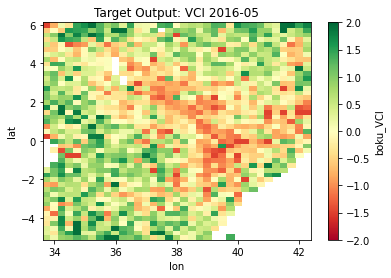

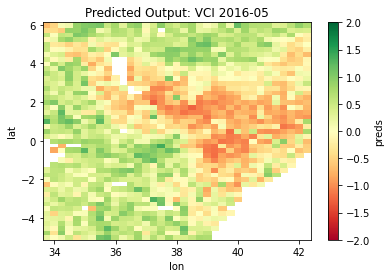

In [163]:
# shap['2016_5'].historical.isel(time=-1)
kwargs = {'cmap': 'RdYlGn', 'vmin':-2, 'vmax':2}
time = '2016-05' 

fig, ax = plt.subplots()
(norm_ds.sel(time=time).boku_VCI).plot(ax=ax, **kwargs)
ax.set_title(f'Target Output: VCI {time}');

fig, ax = plt.subplots()
(norm_pred.sel(time=time)).plot(ax=ax, **kwargs)
ax.set_title(f'Predicted Output: VCI {time}');

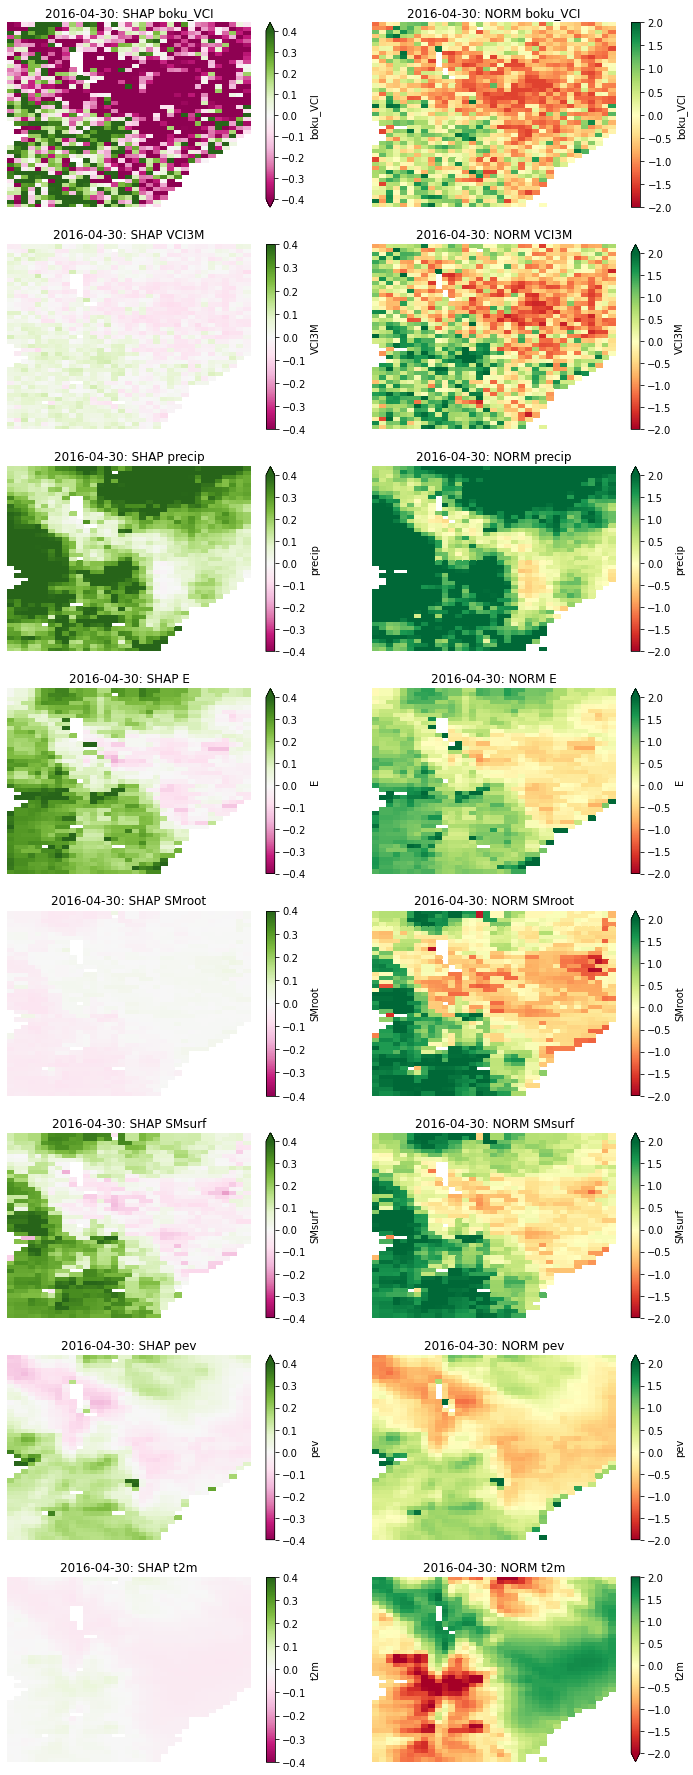

In [112]:
variables = list(ds.drop(ealstm.ignore_vars).data_vars)


plot_shap_obs_pairs(
    shap['2016_5'].historical.isel(time=-1), 
    norm_x_test, 
    variables, 
    {'vmin': -0.4, 'vmax': 0.4, 'cmap': 'PiYG'}, 
    {'cmap': 'RdYlGn', 'vmin':-2, 'vmax':2}, 
    norm=True
)

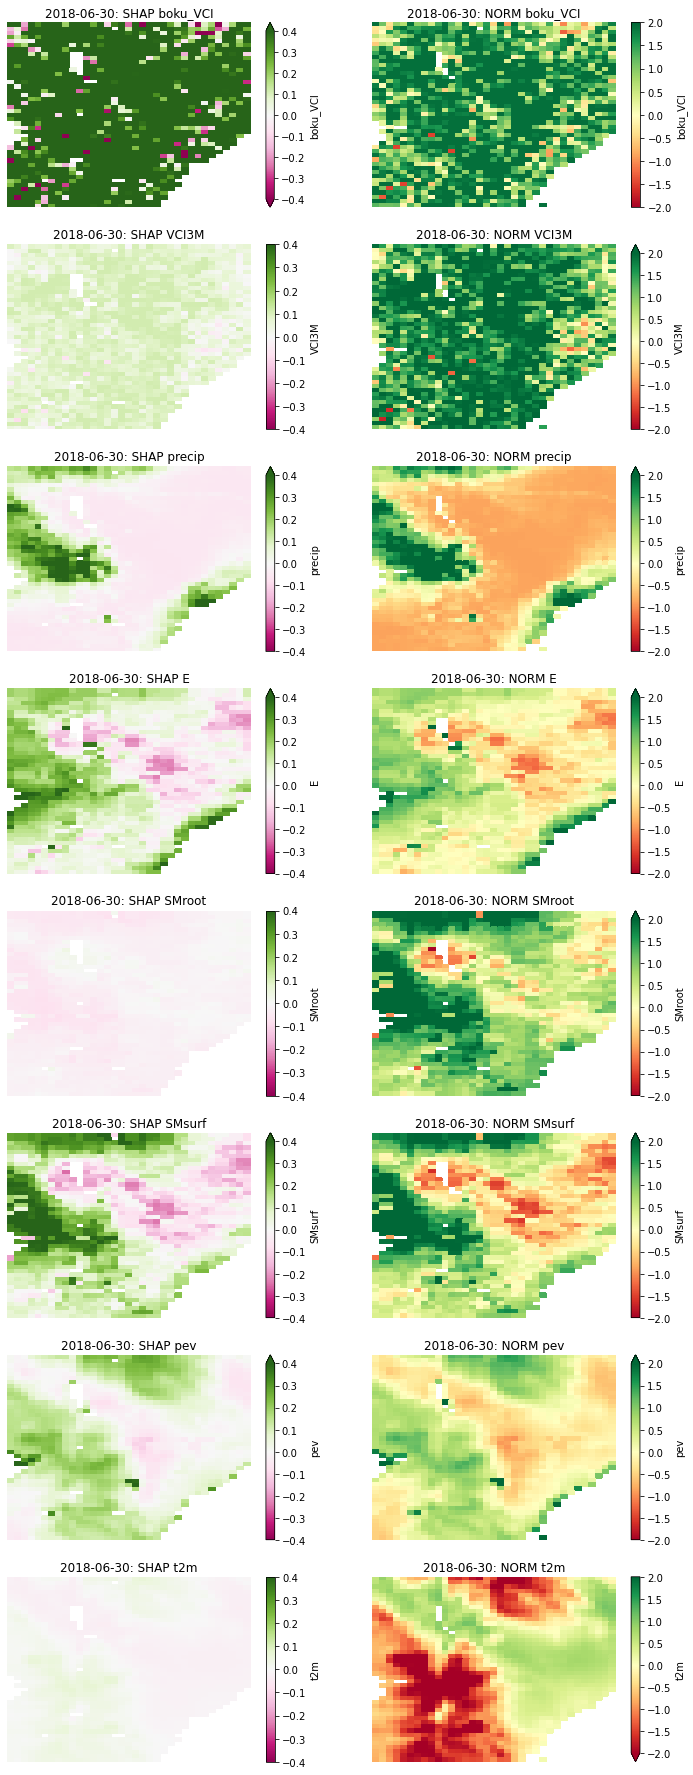

In [113]:
# plot_shap_obs_pairs(shap['2018_2'].historical.isel(time=-1), ds, variables, {'vmin': -0.4, 'vmax': 0.4, 'cmap': 'RdBu_r'}, {'cmap': 'viridis'})
plot_shap_obs_pairs(shap['2018_7'].historical.isel(time=-1), norm_x_test, variables, {'vmin': -0.4, 'vmax': 0.4, 'cmap': 'PiYG'}, {'cmap': 'RdYlGn', 'vmin':-2, 'vmax':2}, norm=True)

# Create One Dataset object

In [114]:
# 1. add target time dimension
shap_t = shap['2018_2']
all_shap = []
for shap_key in ([k for k in shap.keys()]):
    shap_t = shap[shap_key]
    all_shap.append(
        shap_t.historical.expand_dims({'target_time': [shap_t.target_time]})
    )

# 2. merge on the new target_time dimension
all_shap = xr.concat(all_shap, dim='target_time')

In [115]:
# 1. add target time dimension
shap_t = shap['2018_2']
all_shap_t3 = []
for shap_key in ([k for k in shap.keys()]):
    shap_t = shap[shap_key]
    all_shap_t3.append(
        shap_t.historical.isel(time=-1).expand_dims({'target_time': [shap_t.target_time]})
    )

# 2. merge on the new target_time dimension
all_shap_t3 = xr.concat(all_shap_t3, dim='target_time')

In [116]:
# all_shap.isel(target_time=0).dropna(dim='time', how='all')

In [117]:
all_static = []
for shap_key in ([k for k in shap.keys()]):
    shap_t = shap[shap_key]
    all_static.append(
        shap_t.static.expand_dims({'target_time': [shap_t.target_time]})
    )

# 2. merge on the new target_time dimension
all_static = xr.concat(all_static, dim='target_time')

# Mean Importance of each feature
- What is the mean magnitude of each variable? 
- (absolute) // 

Compare with the normalised anomaly for the variable in ds

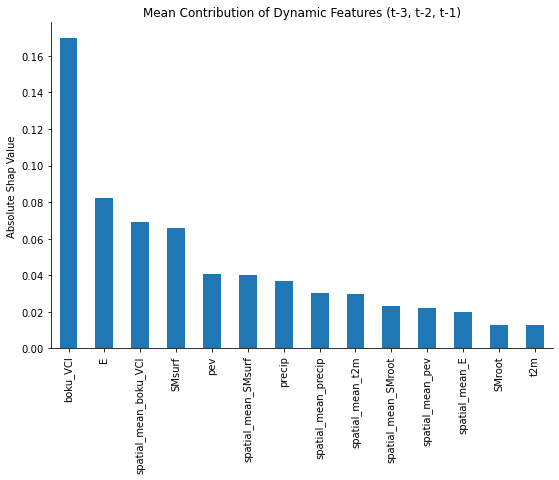

In [118]:
mean_df = np.abs(all_shap).mean().to_array(name='mean_shap').to_dataframe()
mean_df = mean_df.drop([c.name for ix, c in mean_df.iterrows() if 'VCI3M' in c.name])
mean_df = mean_df.sort_values('mean_shap', ascending=False)

scale = 1.5
fig, ax = plt.subplots(figsize=(6*scale, 4*scale))

# plot the mean absolute contribution
mean_df.plot.bar(legend=False, ax=ax)

ax.set_xlabel('')
ax.set_ylabel('Absolute Shap Value')
ax.set_title('Mean Contribution of Dynamic Features (t-3, t-2, t-1)')

ylim = ax.get_ylim()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

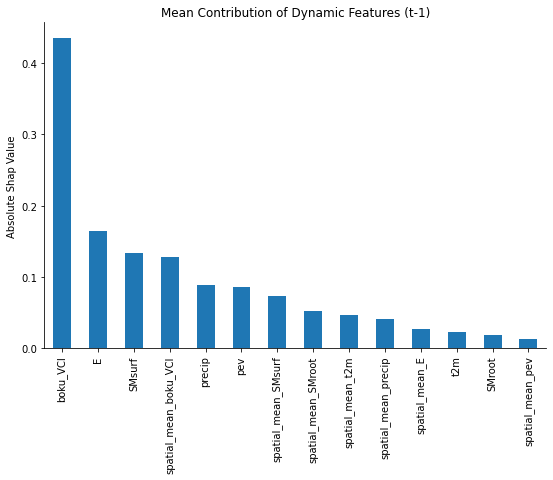

In [119]:
mean_df = np.abs(all_shap_t3).mean().to_array(name='mean_shap').to_dataframe()
mean_df = mean_df.drop([c.name for ix, c in mean_df.iterrows() if 'VCI3M' in c.name])
mean_df = mean_df.sort_values('mean_shap', ascending=False)
scale = 1.5
fig, ax = plt.subplots(figsize=(6*scale, 4*scale))

# plot the mean absolute contribution
mean_df.plot.bar(legend=False, ax=ax)

ax.set_xlabel('')
ax.set_ylabel('Absolute Shap Value')
ax.set_title('Mean Contribution of Dynamic Features (t-1)')

ylim = ax.get_ylim()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

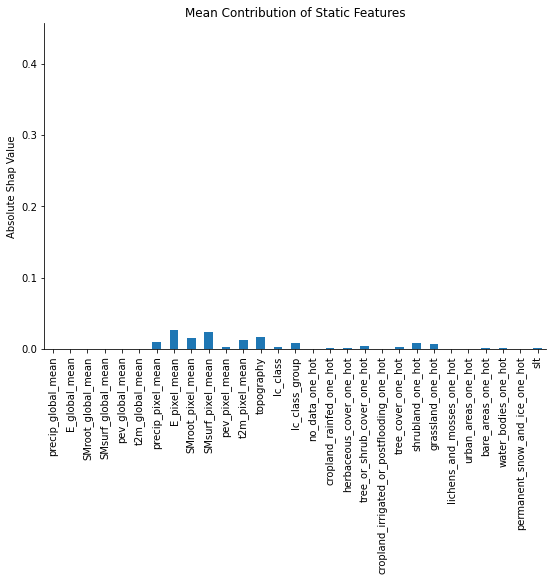

In [120]:
mean_df = np.abs(all_static).mean().to_array(name='mean_shap').to_dataframe()
scale = 1.5
fig, ax = plt.subplots(figsize=(6*scale, 4*scale))

# plot the mean absolute contribution
mean_df.plot.bar(legend=False, ax=ax)

ax.set_xlabel('')
ax.set_ylabel('Absolute Shap Value')
ax.set_title('Mean Contribution of Static Features')
ax.set_ylim(ylim)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# mean spatial patterns

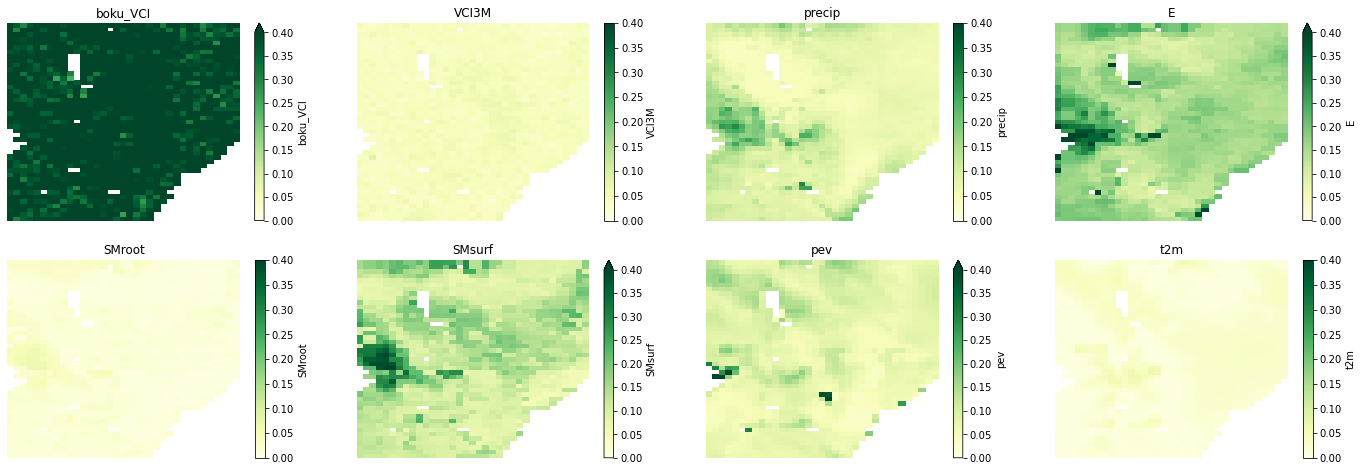

In [121]:
fig, axs = plt.subplots(2, 4, figsize=(6*4, 4*2))
kwargs = dict(vmin=0, vmax=0.4, cmap='YlGn')

for ix, variable in enumerate(variables):
    ax = axs[np.unravel_index(ix, (2, 4))]
    np.abs(all_shap_t3).mean(dim='target_time')[variable].plot(ax=ax, **kwargs)
    ax.axis('off')
    ax.set_title(variable)

# Correlate (OBSERVED, SHAP)

In [122]:
# !pip install git+git://github.com/hrishikeshac/mvstats

In [123]:
import mvstats.mvstats as mv

In [124]:
norm_x_test; all_shap_t3; variables

['boku_VCI', 'VCI3M', 'precip', 'E', 'SMroot', 'SMsurf', 'pev', 't2m']

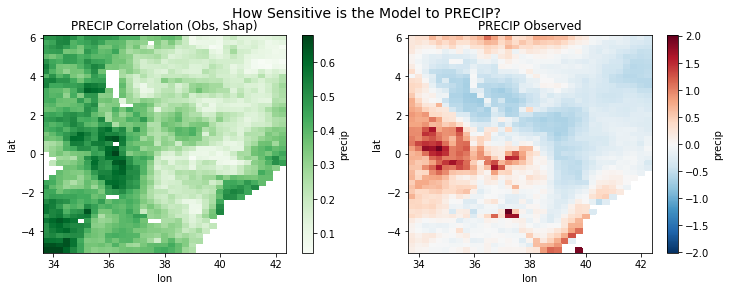

In [125]:
variable = variables[2]
# get the correct time from the OBSERVED data
x = norm_x_test[variable].sel(time=all_shap_t3.time.values)
# rename the dims in the SHAP data
y = all_shap_t3[variable].drop('time').rename({'target_time': 'time'})

assert x.shape == y.shape

# run the correlation for OBS, SHAP
cor = mv.cor(x, y)
# slope, intercept = mv.reg(x, y) 

# plot correlations
fig, axs = plt.subplots(1, 2, figsize=(6*2, 4*1))
cor.plot(ax=axs[0], cmap='Greens')
axs[0].set_title(f"{variable.upper()} Correlation (Obs, Shap)");

x.mean(dim='time').plot(ax=axs[1])
axs[1].set_title(f"{variable.upper()} Observed");

fig.suptitle(f'How Sensitive is the Model to {variable.upper()}?', size=14);

### Correlation of all pixel-time points (`t-1`)

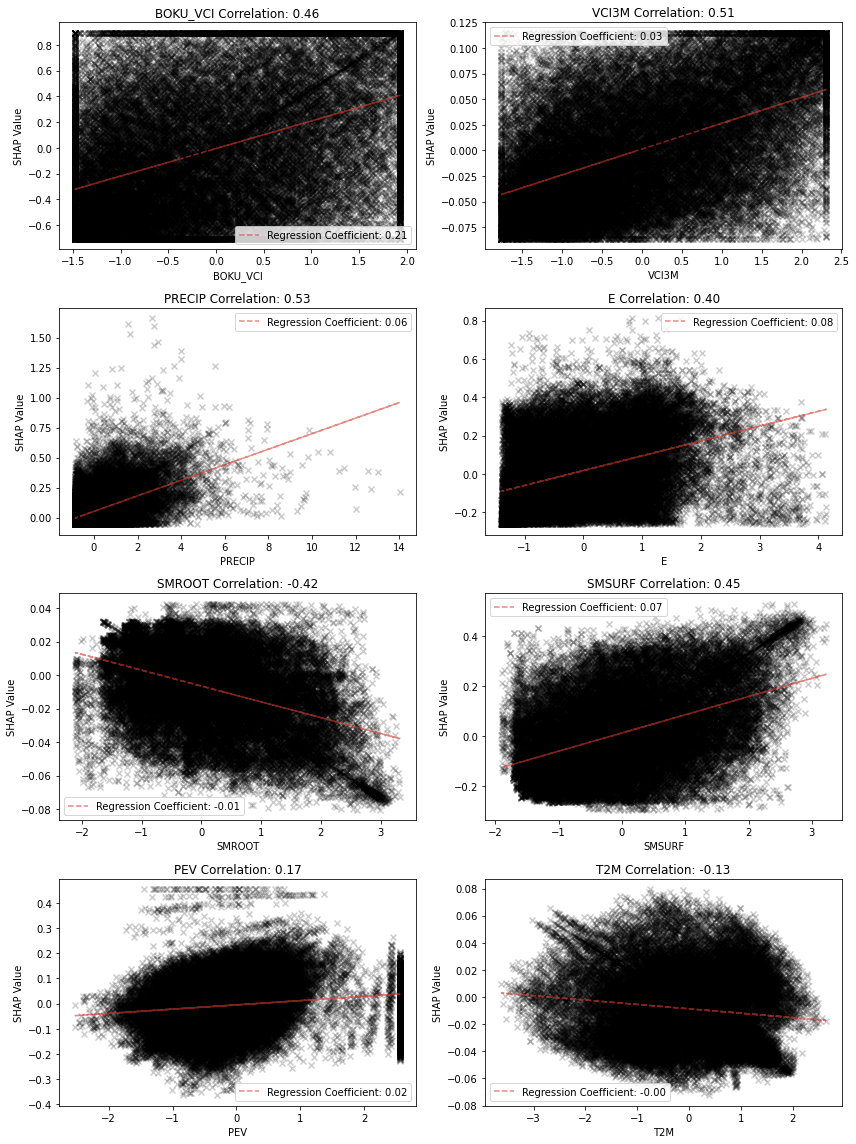

In [126]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr


def get_shap_obs_data(obs_data: xr.Dataset, shap_data: xr.Dataset, variable: str) -> Tuple[np.ndarray]:
    """"""
    # get the correct time from the OBSERVED data
    obs = obs_data[variable].sel(time=shap_data.time.values)
    # rename the dims in the SHAP data
    shap = shap_data[variable].drop('time').rename({'target_time': 'time'})

    assert x.shape == y.shape
    return obs, shap
    

def drop_and_flatten(x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray]:
    """drop nans from indexes in x, y"""
    x_flat = x.values.flatten()
    y_flat = y.values.flatten()

    drop = (np.isnan(x_flat) | np.isnan(y_flat))
    x_flat = x_flat[~drop]
    y_flat = y_flat[~drop]
    
    return x_flat, y_flat


def plot_scatter(x: np.ndarray, y: np.ndarray, variable: str, ax=None):
    """"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
        
    ax.scatter(x, y, alpha=0.2, color='k', marker='x')

    ax.set_title(f"{variable.upper()} Correlation: {np.corrcoef(x, y)[0, 1]:.2f}")
    ax.set_xlabel(variable.upper())
    ax.set_ylabel("SHAP Value");

    # plot regression line
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, (m * x + b), ls='--', label=f'Regression Coefficient: {m:.2f}', color='#d7392e', alpha=0.6)

    ax.legend()
    return ax


fig, axs = plt.subplots(4, 2, figsize=(6*2, 4*4))
for ix, variable in enumerate(variables):
    ax = axs[np.unravel_index(ix, (4,2))]
    x, y = get_shap_obs_data(obs_data=norm_x_test, shap_data=all_shap_t3, variable=variable)
    x, y = drop_and_flatten(x, y)
    ax = plot_scatter(x, y, variable, ax=ax)
fig.tight_layout()

### pixel-based (collapsing space) spatial correlations of the `normalised_observation` and the `shap_values` (`t-1`)

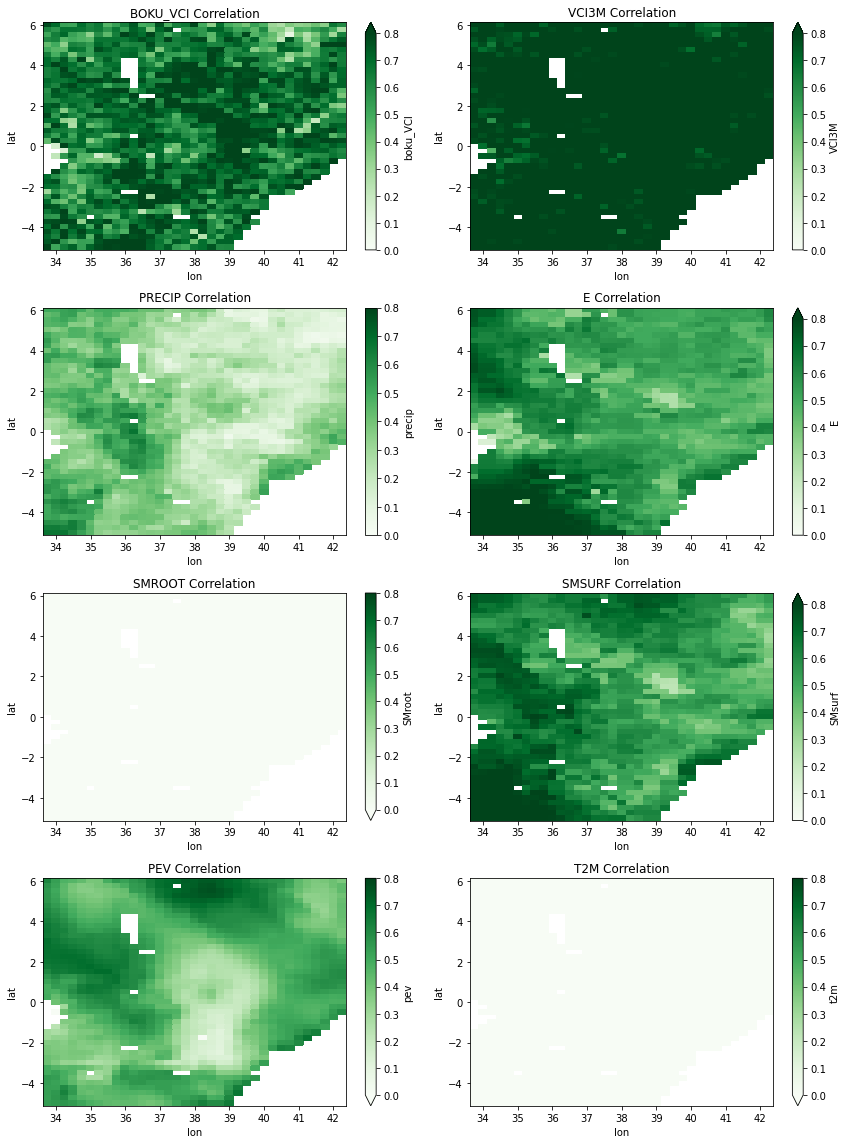

In [127]:
# plot correlations
fig, axs = plt.subplots(4, 2, figsize=(6*2, 4*4))

for ix, variable in enumerate(variables):
    ax = axs[np.unravel_index(ix, (4, 2))]
    x, y = get_shap_obs_data(obs_data=norm_x_test, shap_data=all_shap_t3, variable=variable)
    cor = mv.cor(x, y)
    # slope, intercept = mv.reg(x, y) 

    cor.plot(ax=ax, vmin=0, vmax=0.8, cmap='Greens')
    ax.set_title(f"{variable.upper()} Correlation");
    
fig.tight_layout()

In [128]:
all_shap_t3[variables]

<xarray.Dataset>
Dimensions:      (lat: 45, lon: 35, target_time: 36)
Coordinates:
  * target_time  (target_time) datetime64[ns] 2016-04-30 ... 2018-02-28
  * lat          (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
  * lon          (lon) float64 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
    time         (target_time) datetime64[ns] 2016-03-31 ... 2018-01-31
Data variables:
    boku_VCI     (target_time, lat, lon) float64 0.3186 -0.5231 ... -0.3436
    VCI3M        (target_time, lat, lon) float64 0.06631 0.008304 ... 0.002051
    precip       (target_time, lat, lon) float64 0.2227 0.1992 ... -0.05104
    E            (target_time, lat, lon) float64 0.4462 0.4636 ... -0.2186
    SMroot       (target_time, lat, lon) float64 -0.04315 -0.04051 ... 0.03355
    SMsurf       (target_time, lat, lon) float64 0.2666 0.2694 ... -0.2403
    pev          (target_time, lat, lon) float64 -0.05091 -0.05269 ... -0.09747
    t2m          (target_time, lat, lon) float64 -0.01126 -0.01798 ... -0.00579

# Do we have other models?

In [165]:
[d for d in (data_dir / "models/one_month_forecast_BASE_static_vars").iterdir()]

[PosixPath('data/models/one_month_forecast_BASE_static_vars/rnn'),
 PosixPath('data/models/one_month_forecast_BASE_static_vars/previous_month'),
 PosixPath('data/models/one_month_forecast_BASE_static_vars/ealstm')]

# Are some regions more sensitive to particular variables than others

In [129]:
np.abs(all_static).mean(dim='target_time')

<xarray.Dataset>
Dimensions:                                     (lat: 45, lon: 35)
Coordinates:
  * lat                                         (lat) float64 -5.0 -4.75 ... 6.0
  * lon                                         (lon) float64 33.75 ... 42.25
Data variables:
    precip_global_mean                          (lat, lon) float64 0.0 ... 0.0
    E_global_mean                               (lat, lon) float64 0.0 ... 0.0
    SMroot_global_mean                          (lat, lon) float64 0.0 ... 0.0
    SMsurf_global_mean                          (lat, lon) float64 0.0 ... 0.0
    pev_global_mean                             (lat, lon) float64 0.0 ... 0.0
    t2m_global_mean                             (lat, lon) float64 0.0 ... 0.0
    precip_pixel_mean                           (lat, lon) float64 0.00949 ... 0.00292
    E_pixel_mean                                (lat, lon) float64 0.007677 ... 0.01485
    SMroot_pixel_mean                           (lat, lon) float64 0.01505 ... 0.0247
    SMsurf_pixel_mean                           (lat, lon) float64 0.02373 ... 0.03034
    pev_pixel_mean                              (lat, lon) float64 0.003055 ... 0.003061
    t2m_pixel_mean                              (lat, lon) float64 0.005533 ... 0.0002323
    topography                                  (lat, lon) float64 0.01701 ... 0.009166
    lc_class                                    (lat, lon) float64 0.007613 ... 0.0001025
    lc_class_group                              (lat, lon) float64 0.01473 ... 0.00639
    no_data_one_hot                             (lat, lon) float64 0.0 ... 0.0
    cropland_rainfed_one_hot                    (lat, lon) float64 0.007003 ... 0.00109
    herbaceous_cover_one_hot                    (lat, lon) float64 1.511e-06 ... 1.511e-06
    tree_or_shrub_cover_one_hot                 (lat, lon) float64 0.002758 ... 0.002758
    cropland_irrigated_or_postflooding_one_hot  (lat, lon) float64 0.0 ... 0.0
    tree_cover_one_hot                          (lat, lon) float64 0.001849 ... 0.001849
    shrubland_one_hot                           (lat, lon) float64 0.008879 ... 0.007629
    grassland_one_hot                           (lat, lon) float64 0.004535 ... 0.004535
    lichens_and_mosses_one_hot                  (lat, lon) float64 0.0 ... 0.0
    urban_areas_one_hot                         (lat, lon) float64 0.0 ... 0.0
    bare_areas_one_hot                          (lat, lon) float64 0.0007966 ... 0.0007966
    water_bodies_one_hot                        (lat, lon) float64 0.0 ... 0.0
    permanent_snow_and_ice_one_hot              (lat, lon) float64 0.0 ... 0.0
    slt                                         (lat, lon) float64 0.001669 ... 0.002114

In [ ]:
scale = 0.6
ncol = 5
nrow = 6
kwargs = dict(vmin=0, vmax=0.1, cmap='Greens')
fig, axs = plt.subplots(nrow, ncol, figsize=((6*scale)*ncol, (4*scale)*nrow))

static_abs = np.abs(all_static).mean(dim='target_time')

for ix, variable in enumerate(list(all_static.data_vars)):
    ax = axs[np.unravel_index(ix, (nrow, ncol))]
    static_abs[variable].plot(ax=ax, add_colorbar=False, **kwargs)
    if "one_hot" in variable:
        title = variable.replace('_one_hot', '').upper()
    else:
        title = f"{variable}"
    ax.set_title(title)
    ax.axis('off')

## We calculated the mean above but do individual timesteps vary from this?

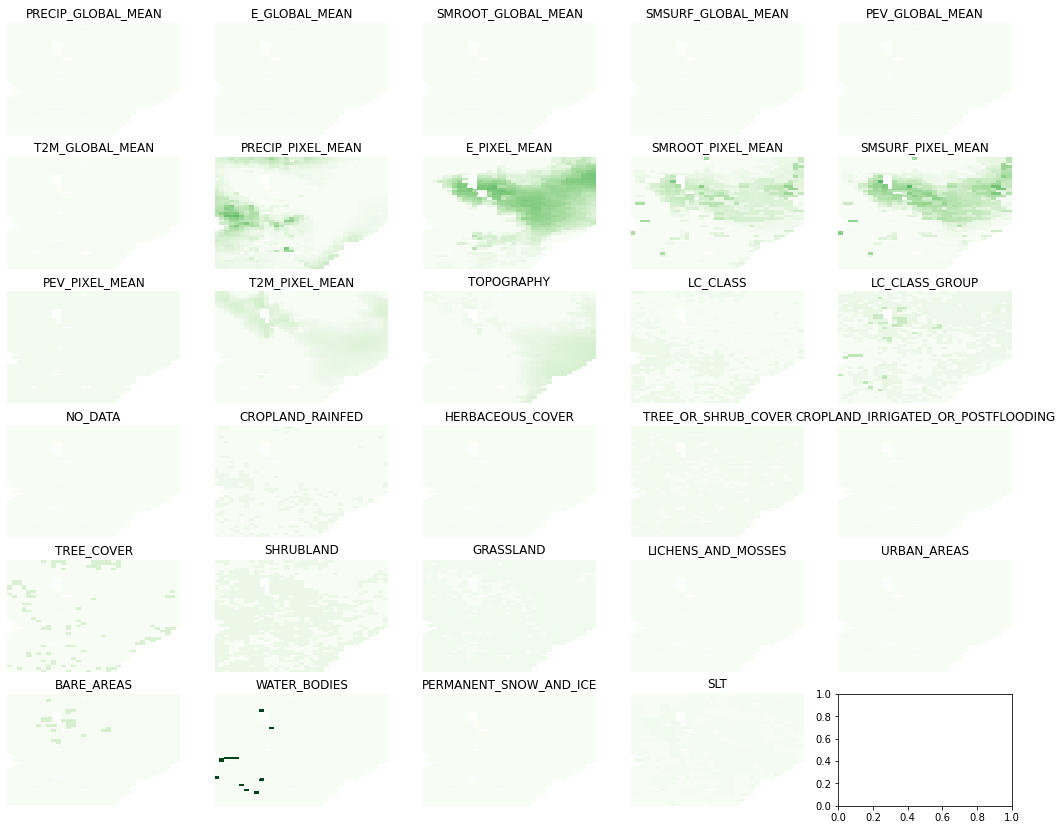

In [131]:
scale = 0.6
ncol = 5
nrow = 6
kwargs = dict(vmin=0, vmax=0.1, cmap='Greens')
fig, axs = plt.subplots(nrow, ncol, figsize=((6*scale)*ncol, (4*scale)*nrow))

static_first = all_static.isel(target_time=0)
static_last = all_static.isel(target_time=-1)


for ix, variable in enumerate(list(all_static.data_vars)):
    ax = axs[np.unravel_index(ix, (nrow, ncol))]
    static_first[variable].plot(ax=ax, add_colorbar=False, **kwargs)
    if "one_hot" in variable:
        title = variable.replace('_one_hot', '').upper()
    else:
        title = f"{variable.upper()}"
    ax.set_title(title)
    ax.axis('off')

## Does the response of the model to static variables change over time?

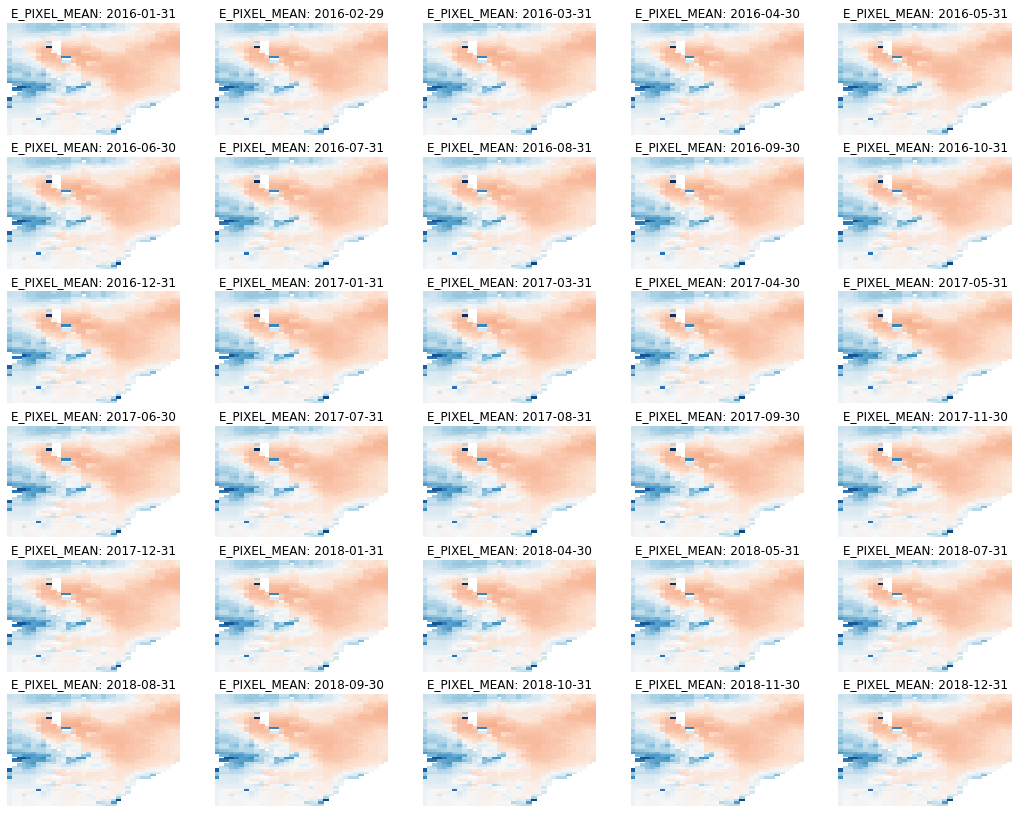

In [132]:
variable = 'E_pixel_mean'
static_times = all_static.isel(target_time=slice(0, 30))[variable].sortby('target_time')

kwargs = dict()

fig, axs = plt.subplots(nrow, ncol, figsize=((6*scale)*ncol, (4*scale)*nrow))

for ix, time in enumerate(static_times.target_time.values):
    ax = axs[np.unravel_index(ix, (nrow, ncol))]
    static_times.sel(target_time=time).plot(ax=ax, add_colorbar=False, **kwargs)
    title = f"{variable.upper()}: {pd.to_datetime(time)._date_repr}"
    ax.set_title(title)
    ax.axis('off')

# Compare performance in the LEARNED clusters

In [133]:
cluster_ds = xr.open_dataset(data_dir/'tommy/cluster_ds.nc')
cluster_ds['time'] = pd.date_range('2018-01', '2019-01', freq='M')
cluster_ds

<xarray.Dataset>
Dimensions:    (lat: 45, lon: 35, time: 12)
Coordinates:
  * lat        (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
  * lon        (lon) float64 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * time       (time) datetime64[ns] 2018-01-31 2018-02-28 ... 2018-12-31
Data variables:
    cluster_5  (time, lat, lon) float64 ...
    month      (time) int64 ...

In [134]:
from src.utils import create_shape_aligned_climatology

variable = 'precip'
time_period = 'month'

shap_ds = all_shap_t3[variables].drop('time').rename({'target_time': 'time'})
ds_clusters = create_shape_aligned_climatology(
    shap_ds, 
    cluster_ds.rename({'time': 'month_'}).rename({'cluster_5': 'precip'}), 
    'precip', 
    'month'
).rename({'precip': 'cluster_5'})

da_clusters = ds_clusters.cluster_5

display(ds_clusters)

<xarray.Dataset>
Dimensions:    (lat: 45, lon: 35, time: 36)
Coordinates:
  * lat        (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
  * lon        (lon) float64 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * time       (time) datetime64[ns] 2016-04-30 2016-05-31 ... 2018-02-28
Data variables:
    cluster_5  (time, lat, lon) float64 3.0 3.0 2.0 3.0 2.0 ... 4.0 4.0 2.0 4.0